example from https://h3-pandas.readthedocs.io/en/latest/notebook/01-unified-data-layers.html

In [1]:
import pandas as pd
import geopandas as gpd
import h3pandas
import matplotlib.pyplot as plt

# Putting point data onto the h3 hex grid

In [4]:
# nyc noise complaint points
noise_311_link = 'https://gist.githubusercontent.com/kashuk/670a350ea1f9fc543c3f6916ab392f62/raw/4c5ced45cc94d5b00e3699dd211ad7125ee6c4d3/NYC311_noise.csv'

df311 = pd.read_csv(noise_311_link)
df311.head()

,lat,lng
0,40.744989,-73.924964
1,40.590929,-74.072404
2,40.728413,-73.994252
3,40.603440,-74.011571
4,40.737613,-74.002905


In [5]:
# creating the hex grid and putting the noise complaint data points onto the hex grid 
# this is operating on the df311 which has columns lat,lng
# the default operation of geo_to_h3_aggregate is sum
# this function sums the lat lng points per h3 hexagon and 
# returns a df with the hex id as the index and the hex polygon as the geometry

hexsize=9
df311 = (df311.assign(count=1).h3.geo_to_h3_aggregate(hexsize))
df311.head()

,count,geometry
h3_09,,
892a100002bffff,2,"POLYGON ((-73.78386 40.85219, -73.78597 40.851..."
892a1000047ffff,2,"POLYGON ((-73.79056 40.85996, -73.79267 40.859..."
892a1000063ffff,6,"POLYGON ((-73.79038 40.85467, -73.79249 40.853..."
892a1000067ffff,5,"POLYGON ((-73.78814 40.85208, -73.79025 40.851..."
892a1000077ffff,1,"POLYGON ((-73.78609 40.85478, -73.78820 40.853..."


this is very nice but I wonder how much flexibility is possible for different types of aggregation or different column names

Text(0.5, 1.0, 'hex-grid: noise complaints')

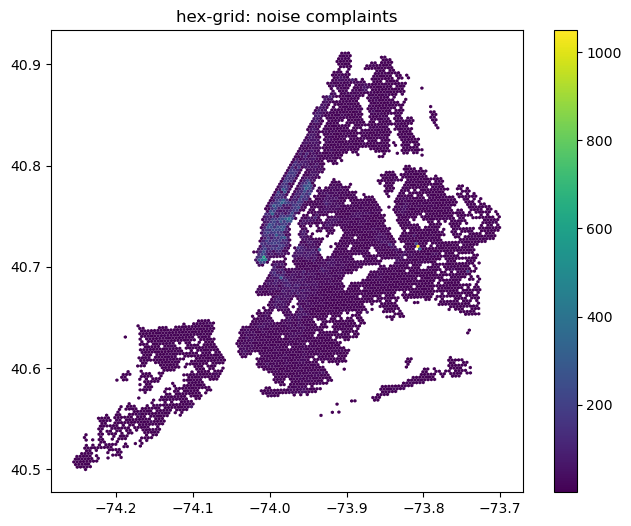

In [9]:
df311.plot(figsize=(8, 6), column='count', cmap='viridis', edgecolor='none', legend=True)
plt.title('hex-grid: noise complaints')

this method does not create a hex where there are no data points, so that's a problem. We would have to create the grid from an overall boundary first, then join the data points. Not a big deal though

# Filling polygons with the hex grid and plotting the polygon data on the hexes

In [11]:
# census tract polygons
ct_shape_link = 'https://gist.githubusercontent.com/kashuk/d73342adeccbc65de7a53e19ad78b4df/raw/4300dcb80861d454ecae8f8429166e196779fc21/CT_simplified_shape.json'

# census tract data
ct_data_link = 'https://gist.githubusercontent.com/kashuk/e6e3e3d8fde34da1212b59248a7cc5a8/raw/da3b63c1c0ef4a1c8cc8e10f61455c436a0d0ad9/CT_data.csv'

In [13]:
# column common to both data files
INDEX_COL = 'BoroCT2010'  # census tract numbers

# data column we want
METRIC_COL = 'SE_T002_002' # population density

In [12]:
# reading census tract polygons
gdf = gpd.read_file(ct_shape_link).drop(columns='gdf').astype({INDEX_COL: str}).set_index(INDEX_COL)
gdf.head()

,geometry
BoroCT2010,
5000900,"POLYGON ((-74.07921 40.64344, -74.07885 40.642..."
5012500,"POLYGON ((-74.11619 40.62895, -74.11326 40.623..."
5013301,"POLYGON ((-74.11720 40.63458, -74.12024 40.634..."
5019700,"POLYGON ((-74.13122 40.61727, -74.13074 40.612..."
5002002,"POLYGON ((-74.06351 40.60216, -74.06106 40.599..."


In [14]:
# reading census tract population density
df = pd.read_csv(ct_data_link, usecols=[INDEX_COL,METRIC_COL], dtype={INDEX_COL: str}).set_index(INDEX_COL)
df.head()

,SE_T002_002
BoroCT2010,
1000100,0.00
1000201,81083.38
1000202,69490.30
1000500,0.00
1000600,117927.10


In [15]:
# joining the census tract data values to the census tract boundaries
# using the census tract number as the join column (which is set to the index in both dataframes)
gdf = gdf.join(df)

# data cleaning
gdf[METRIC_COL] = gdf[METRIC_COL].fillna(0) # fill nans
gdf = gdf.loc[~gdf.geometry.isna()] # drop any tracts that are missing the polygon boundary

# here, geometry column is the census tract polygons
gdf.head()

In [18]:
# fill census tract polygons with hex grid
# this function polyfill_resample is marked as experimental
hexsize=10
dfh = gdf.h3.polyfill_resample(hexsize)

# here, geometry column is the hex grid polygons
dfh.head()

,BoroCT2010,geometry,SE_T002_002
h3_polyfill,,,
8a2a1070baaffff,5000900,"POLYGON ((-74.08014 40.64454, -74.08105 40.644...",22976.0
8a2a1070b307fff,5000900,"POLYGON ((-74.08371 40.64217, -74.08462 40.642...",22976.0
8a2a1070b3affff,5000900,"POLYGON ((-74.08643 40.64172, -74.08734 40.641...",22976.0
8a2a1070ba9ffff,5000900,"POLYGON ((-74.08287 40.64408, -74.08378 40.643...",22976.0
8a2a1070bad7fff,5000900,"POLYGON ((-74.08098 40.64263, -74.08189 40.642...",22976.0


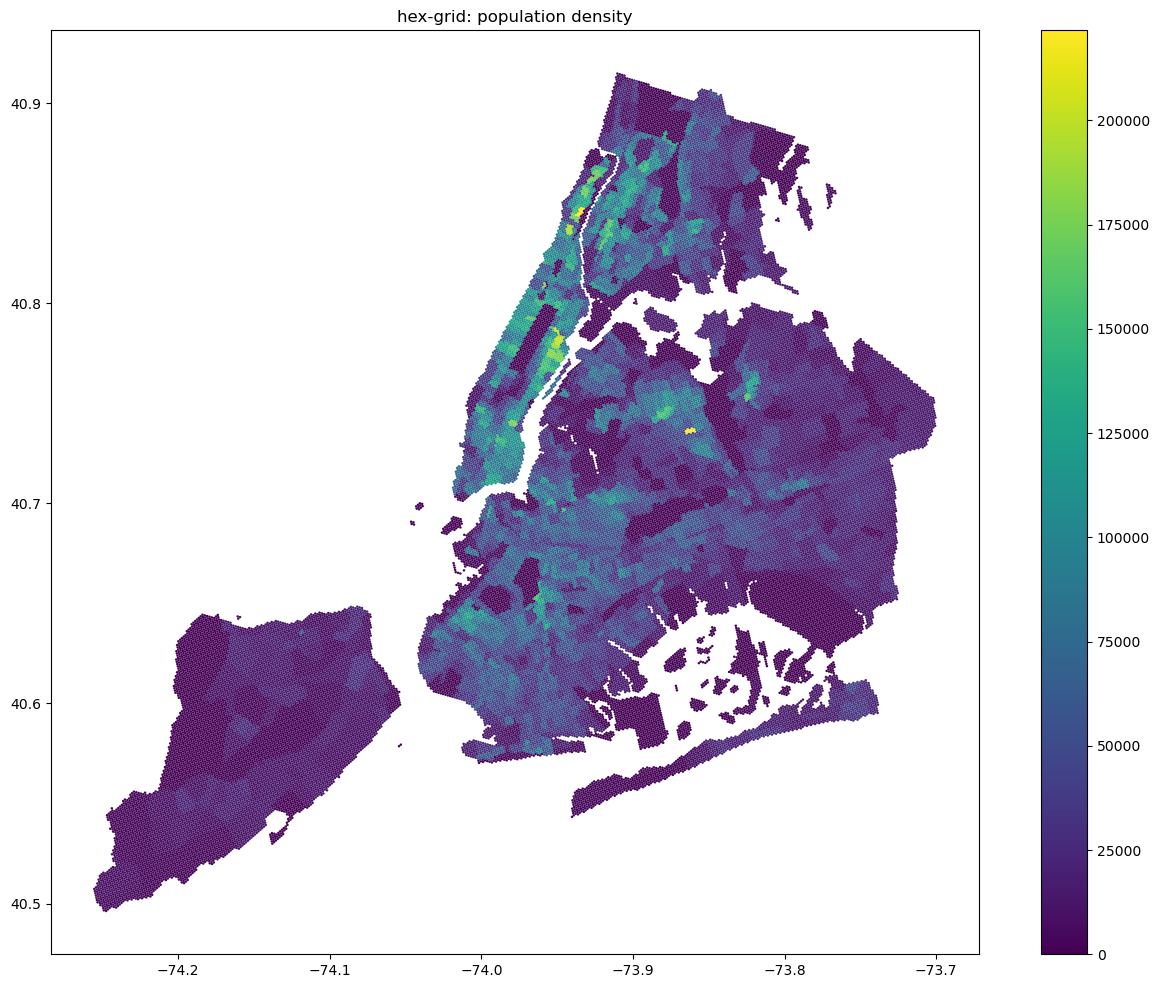

In [19]:
dfh.plot(figsize=(16, 12), column=METRIC_COL, legend=True)
plt.title('hex-grid: population density');

if we went from polygon to polygon (census tracts to h3 grid) we need to check if any of the hexes are overlapping (same hex assigned to multiple tracts) because we saw that problem with the h3 package

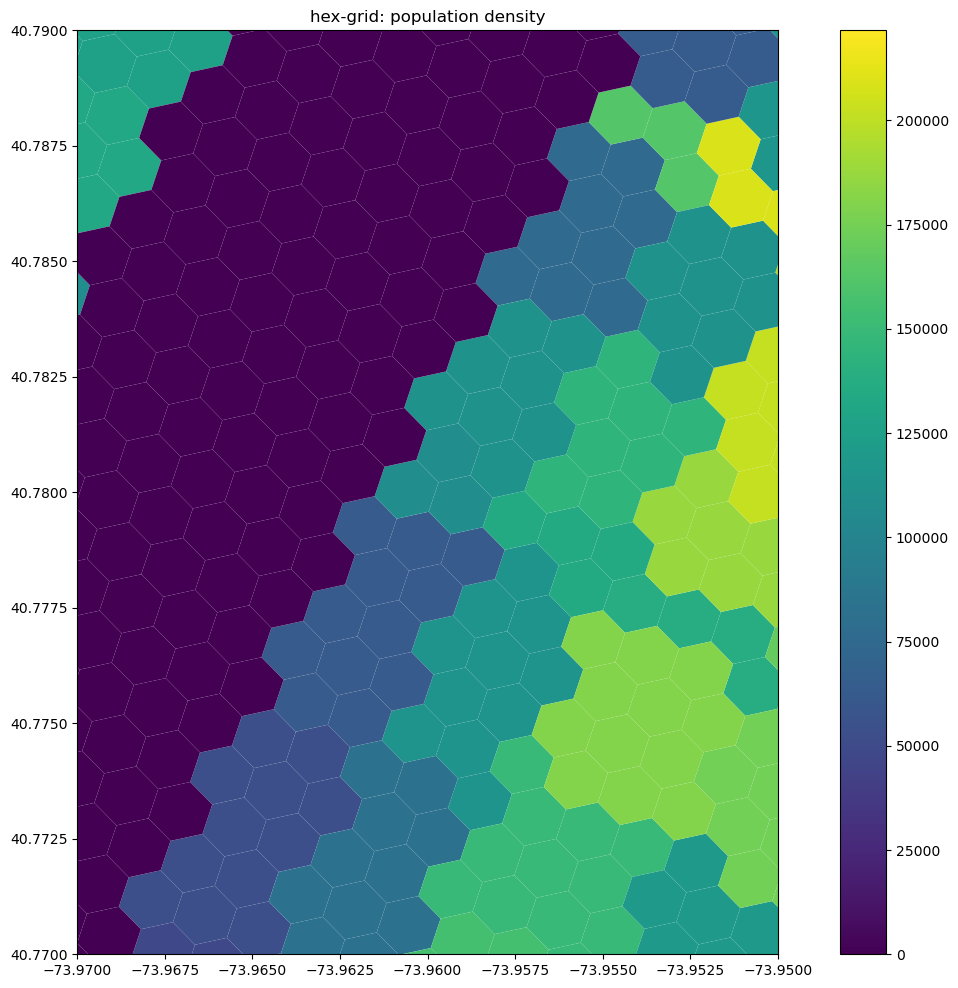

In [28]:
# zoom in on some tract to look for overlaps
fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
dfh.plot(ax=ax, column=METRIC_COL, legend=True)
ax.set_xlim(-73.97,-73.95)
ax.set_ylim(40.77,40.79)

plt.title('hex-grid: population density');

it doesn't look like any are overlaps, but we can't be sure from this plot. 

If there are no overlaps, that means h3pandas is doing something behind the scenes that is not obvious to the user or documented well in the function description. No overlaps means it's matching the hex centroid (instead of polygon) to the census tract polygons.

Ok, if you look to the code for polyfill_resample on github https://github.com/DahnJ/H3-Pandas/blob/master/h3pandas/h3pandas.py it does say it's using the hex centroids
```
        Returns
        -------
        (Geo)DataFrame with H3 cells with centroids within the input polygons.
```
Use of the centroid is also documented in the function description for polyfill although you shouldn't have to go to a different function description to understand what's going on in polyfill_resample
https://h3-pandas.readthedocs.io/en/latest/h3pandas.html#h3pandas.h3pandas.H3Accessor.polyfill

# Let's try putting the noise data points on the hex grid created from the census tracts

In [ ]:
nyc_dem_link = 'https://gist.githubusercontent.com/DahnJ/5b77a1d7047412e35e0c1f9ff10ea182/raw/b328c6beb369127081287ac2a17820280d35898b/dem_nyc_xyz.csv'